# 准备数据

In [1]:
# 加载模块
import polars as pl 
## 与Pandas类似，但性能更好

from vnpy.trader.constant import Interval
## 用于表示K线周期的枚举类型，如日线、周线、月线等，常用来指定数据的时间粒度
from vnpy.alpha import AlphaLab
## alpha是VNPY4.0的新功能

In [2]:
# 创建数据中心
lab: AlphaLab = AlphaLab("./lab/csi300") #沪深300指数

In [3]:
# 设置任务参数
name = "lstm"
index_symbol: str = "000300.SSE" 
start: str = "2008-01-01"
end: str = "2020-08-01"
interval: Interval = Interval.DAILY
extended_days: int = 100
# 设置扩展天数为 100。这个参数通常用于在提取数据时，向前或向后多取一些天数，便于特征工程、滑动窗口等操作。

In [4]:
# 加载所有成分股代码
component_symbols: list[str] = lab.load_component_symbols(index_symbol, start, end)

# 特征计算

In [5]:
# 加载模块
from datetime import datetime
# 导入标准库 datetime 模块中的 datetime 类，用于处理日期和时间。
from functools import partial
# 导入标准库 functools 模块中的 partial 函数，用于部分应用函数。
from vnpy.trader.constant import Interval
# 导入VNPY库中的 Interval 枚举类型，用于表示时间间隔。
from vnpy.alpha.dataset import (
    AlphaDataset, #因子数据集的核心类，用于存储和管理特征、标签等。
    process_drop_na, # 处理缺失值，删除包含 NaN 的行。
    process_robust_zscore_norm, # 对数据进行鲁棒 Z 分数归一化。
    process_fill_na, # 填充缺失值，使用均值或中位数填充。
    process_cs_rank_norm, # 对数据进行累积排名归一化。
    to_datetime # 将字符串转换为 datetime 对象。
)
from vnpy.alpha.dataset.datasets.alpha_158 import Alpha158
# 导入VNPY库中的 Alpha158 类，用于加载Alpha158因子数据集。

In [6]:
# 加载成分股数据
df: pl.DataFrame = lab.load_bar_df(component_symbols, interval, start, end, extended_days)

In [7]:
# 设置数据时间段
train_period: tuple[str, str] = ("2008-01-01", "2014-12-31")
valid_period: tuple[str, str] = ("2015-01-01", "2016-12-31")
test_period: tuple[str, str] = ("2017-01-01", "2020-8-31")

In [8]:
# 创建数据集对象
dataset: AlphaDataset = Alpha158(
    df,
    train_period=train_period,
    valid_period=valid_period,
    test_period=test_period,
)

In [9]:
# 添加数据预处理器
fit_start_time: datetime = to_datetime(train_period[0])
fit_end_time: datetime = to_datetime(train_period[1])

dataset.add_processor("infer", partial(process_robust_zscore_norm, fit_start_time=fit_start_time, fit_end_time=fit_end_time))
dataset.add_processor("infer", partial(process_fill_na, fill_value=0, fill_label=False))

dataset.add_processor("learn", partial(process_drop_na, names=["label"]))
dataset.add_processor("learn", partial(process_cs_rank_norm, names=["label"]))

In [10]:
# 收集指数成分过滤器
filters: dict[str, list[str]] = lab.load_component_filters(index_symbol, start, end)

In [11]:
# 准备特征和标签数据
# dataset.prepare_data(filters,max_workers=8) 
# 上文已经加载了数据，这里直接使用

In [12]:
# 保存到文件缓存
# lab.save_dataset(name, dataset)

# 模型训练

In [13]:
# 加载模块
import numpy as np

from vnpy.alpha.dataset import Segment
from vnpy.alpha.model import AlphaModel

from lstm_model import LstmModel

In [14]:
dataset: AlphaDataset = lab.load_dataset(name)

In [36]:
kwargs = {
    "input_size": 158, #使用alpha158因子
    "hidden_size": 128, #LSTM隐藏层神经元数量
    "num_layers": 6, #LSTM层数
    "dropout": 0.3, #Dropout比率，用于防止过拟合
    "n_epochs": 500, #训练轮数
    "lr": 1e-3, #学习率
    "early_stop_rounds": 20, #早停轮数
    "batch_size": 512, #每批训练样本数
    "seed": 42
}

In [37]:
model: AlphaModel = LstmModel(**kwargs)

In [38]:
model.fit(dataset)

2025-07-24 23:11:04 Epoch 0:
2025-07-24 23:11:04 training...
2025-07-24 23:11:17 evaluating...
2025-07-24 23:11:25 train -0.984922, valid -0.989396
2025-07-24 23:11:25 Epoch 1:
2025-07-24 23:11:25 training...
2025-07-24 23:11:39 evaluating...
2025-07-24 23:11:48 train -0.981333, valid -0.991741
2025-07-24 23:11:48 Epoch 2:
2025-07-24 23:11:48 training...
2025-07-24 23:12:04 evaluating...
2025-07-24 23:12:13 train -0.975351, valid -0.993265
2025-07-24 23:12:13 Epoch 3:
2025-07-24 23:12:13 training...
2025-07-24 23:12:27 evaluating...
2025-07-24 23:12:36 train -0.972560, valid -0.995915
2025-07-24 23:12:36 Epoch 4:
2025-07-24 23:12:36 training...
2025-07-24 23:12:51 evaluating...
2025-07-24 23:13:01 train -0.969247, valid -0.994006
2025-07-24 23:13:01 Epoch 5:
2025-07-24 23:13:01 training...
2025-07-24 23:13:14 evaluating...
2025-07-24 23:13:24 train -0.967022, valid -0.994384
2025-07-24 23:13:24 Epoch 6:
2025-07-24 23:13:24 training...
2025-07-24 23:13:38 evaluating...
2025-07-24 23:13:

In [39]:
# 查看模型细节
model.detail()

2025-07-24 23:19:18 输入特征维度: 158
2025-07-24 23:19:18 LSTM隐藏层数量: 6
2025-07-24 23:19:18 每层神经元数量: 128
2025-07-24 23:19:18 模型总参数量: 808,065
2025-07-24 23:19:18 训练设备: cuda
2025-07-24 23:19:18 当前学习率: 0.001
2025-07-24 23:19:18 批次大小: 512


Importance
Feature            
rank_5     0.002055
rank_10    0.001494
imin_5     0.001432
std_5      0.001430
imin_10    0.001237
...             ...
cntn_20    0.000167
vma_30     0.000161
cord_10    0.000160
vma_60     0.000152
qtlu_60    0.000136

[158 rows x 1 columns]

In [40]:
# 用模型在测试集上预测
pre: np.ndarray = model.predict(dataset, Segment.TEST)

# 加载测试集数据
df_t: pl.DataFrame = dataset.fetch_infer(Segment.TEST)

# 合并预测信号列
df_t = df_t.with_columns(pl.Series(pre).alias("signal"))

# 提取信号数据
signal: pl.DataFrame = df_t["datetime", "vt_symbol", "signal"]

In [41]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # 忽略重复加载警告

C:\Users\11986\AppData\Roaming\Python\Python312\site-packages\alphalens\utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\11986\AppData\Roaming\Python\Python312\site-packages\alphalens\utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

C:\Users\11986\AppData\Roaming\Python\Python312\site-packages\alphalens\utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.341964 -0.011653 -0.160955  0.061770  25830  10.000000
2               -0.296961  0.029429 -0.085191  0.045603  25830  10.000000
3               -0.269659  0.064504 -0.049541  0.042028  25830  10.000000
4               -0.243064  0.086801 -0.023723  0.039117  25830  10.000000
5               -0.221996  0.107858 -0.002091  0.036582  25831  10.000387
6               -0.196628  0.128526  0.017240  0.034438  25830  10.000000
7               -0.177080  0.143666  0.035602  0.032157  25833  10.001161
8               -0.143543  0.156659  0.054153  0.029710  25829   9.999613
9               -0.106441  0.170968  0.074846  0.028229  25828   9.999226
10              -0.057383  0.199917  0.111130  0.031206  25829   9.999613

Returns Analysis


1D      5D     10D
Ann. alpha                                      0.386   0.204   0.109
beta                                           -0.002  -0.006  -0.022
Mean Period Wise Return Top Quantile (bps)     20.726  11.923   7.635
Mean Period Wise Return Bottom Quantile (bps) -16.758  -9.786  -4.708
Mean Period Wise Spread (bps)                  37.484  21.708  12.332

<Figure size 640x480 with 0 Axes>

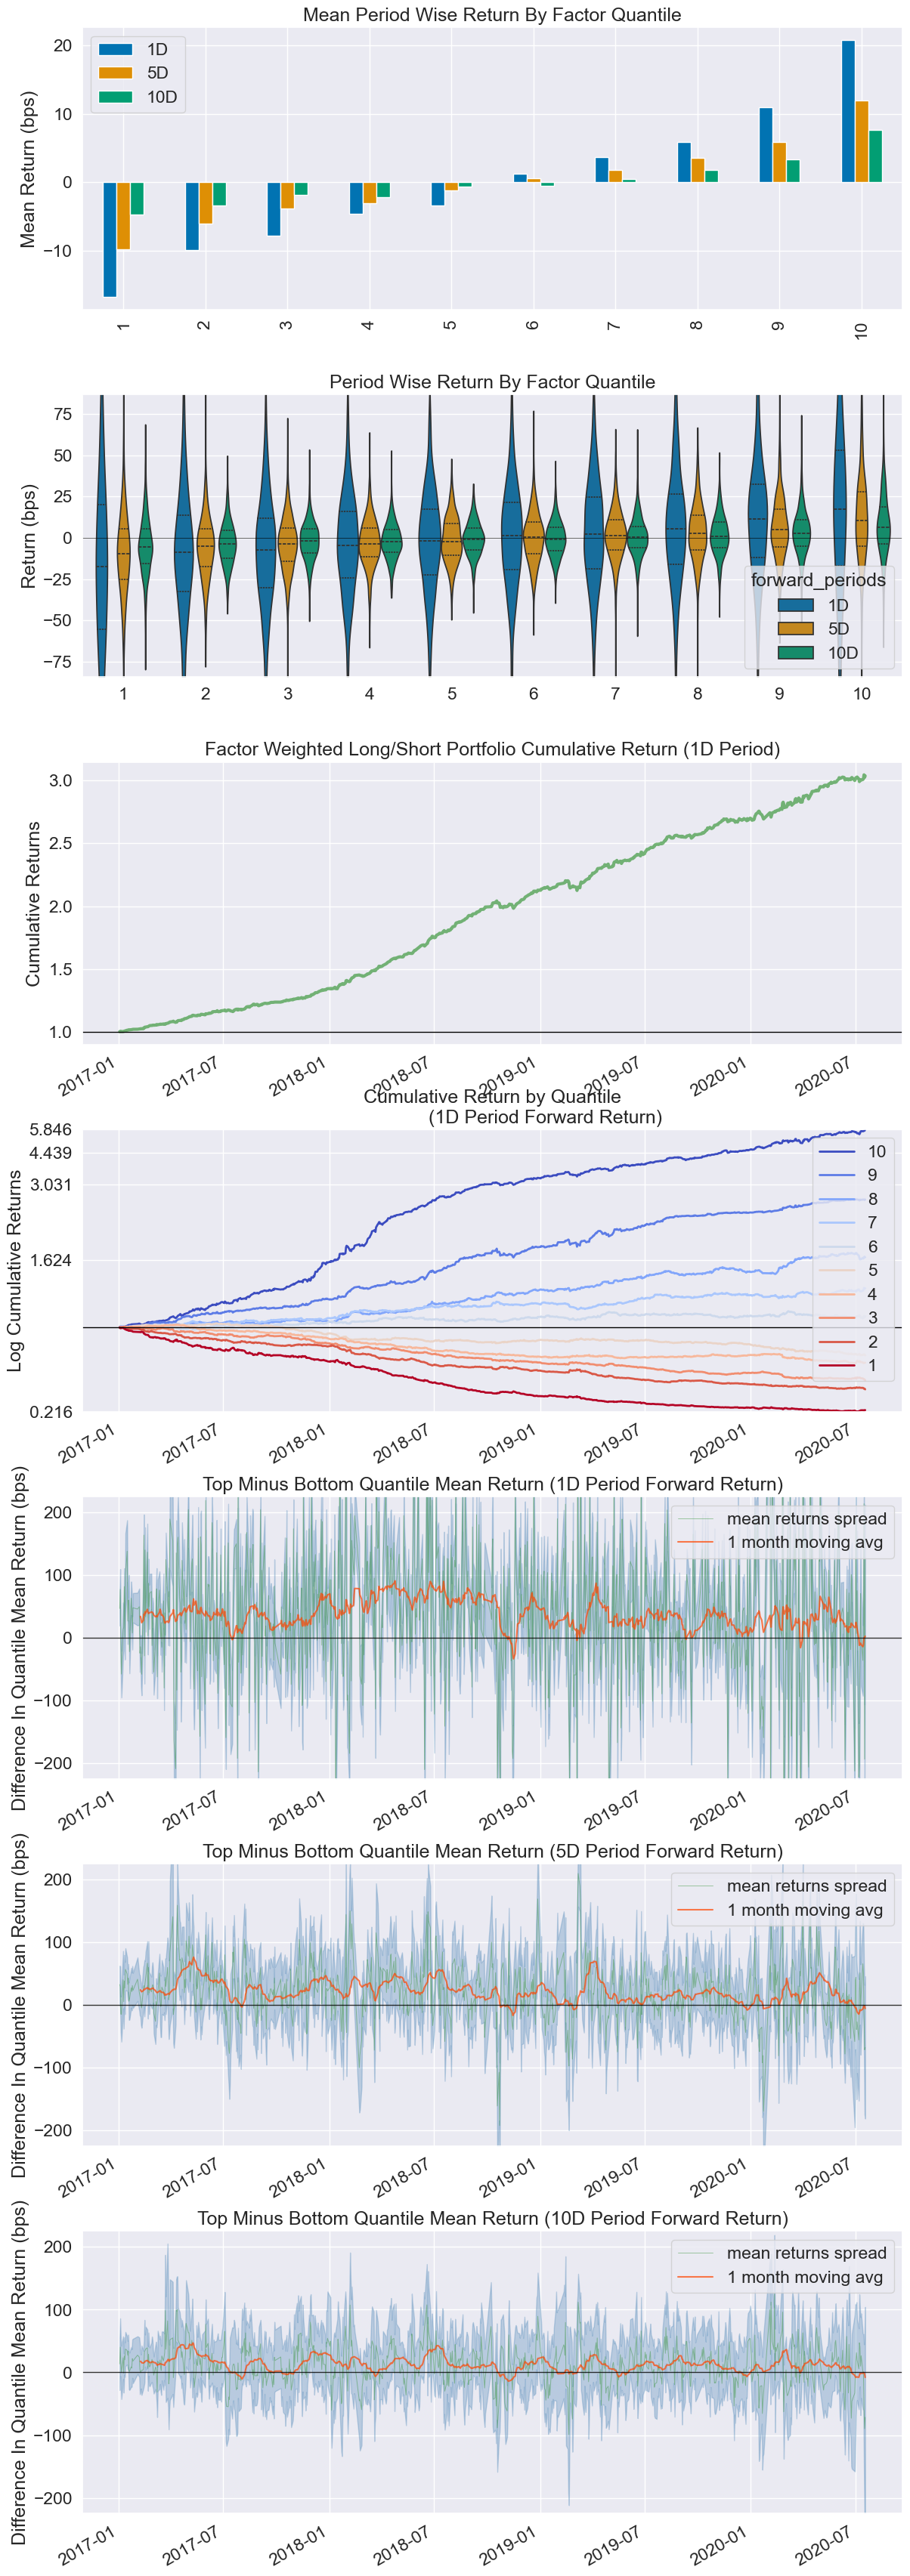

Information Analysis


1D      5D     10D
IC Mean            0.076   0.083   0.066
IC Std.            0.133   0.128   0.123
Risk-Adjusted IC   0.573   0.646   0.534
t-stat(IC)        16.800  18.960  15.668
p-value(IC)        0.000   0.000   0.000
IC Skew           -0.033   0.120  -0.013
IC Kurtosis        0.373   0.158   0.220

C:\Users\11986\AppData\Roaming\Python\Python312\site-packages\alphalens\performance.py:118: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



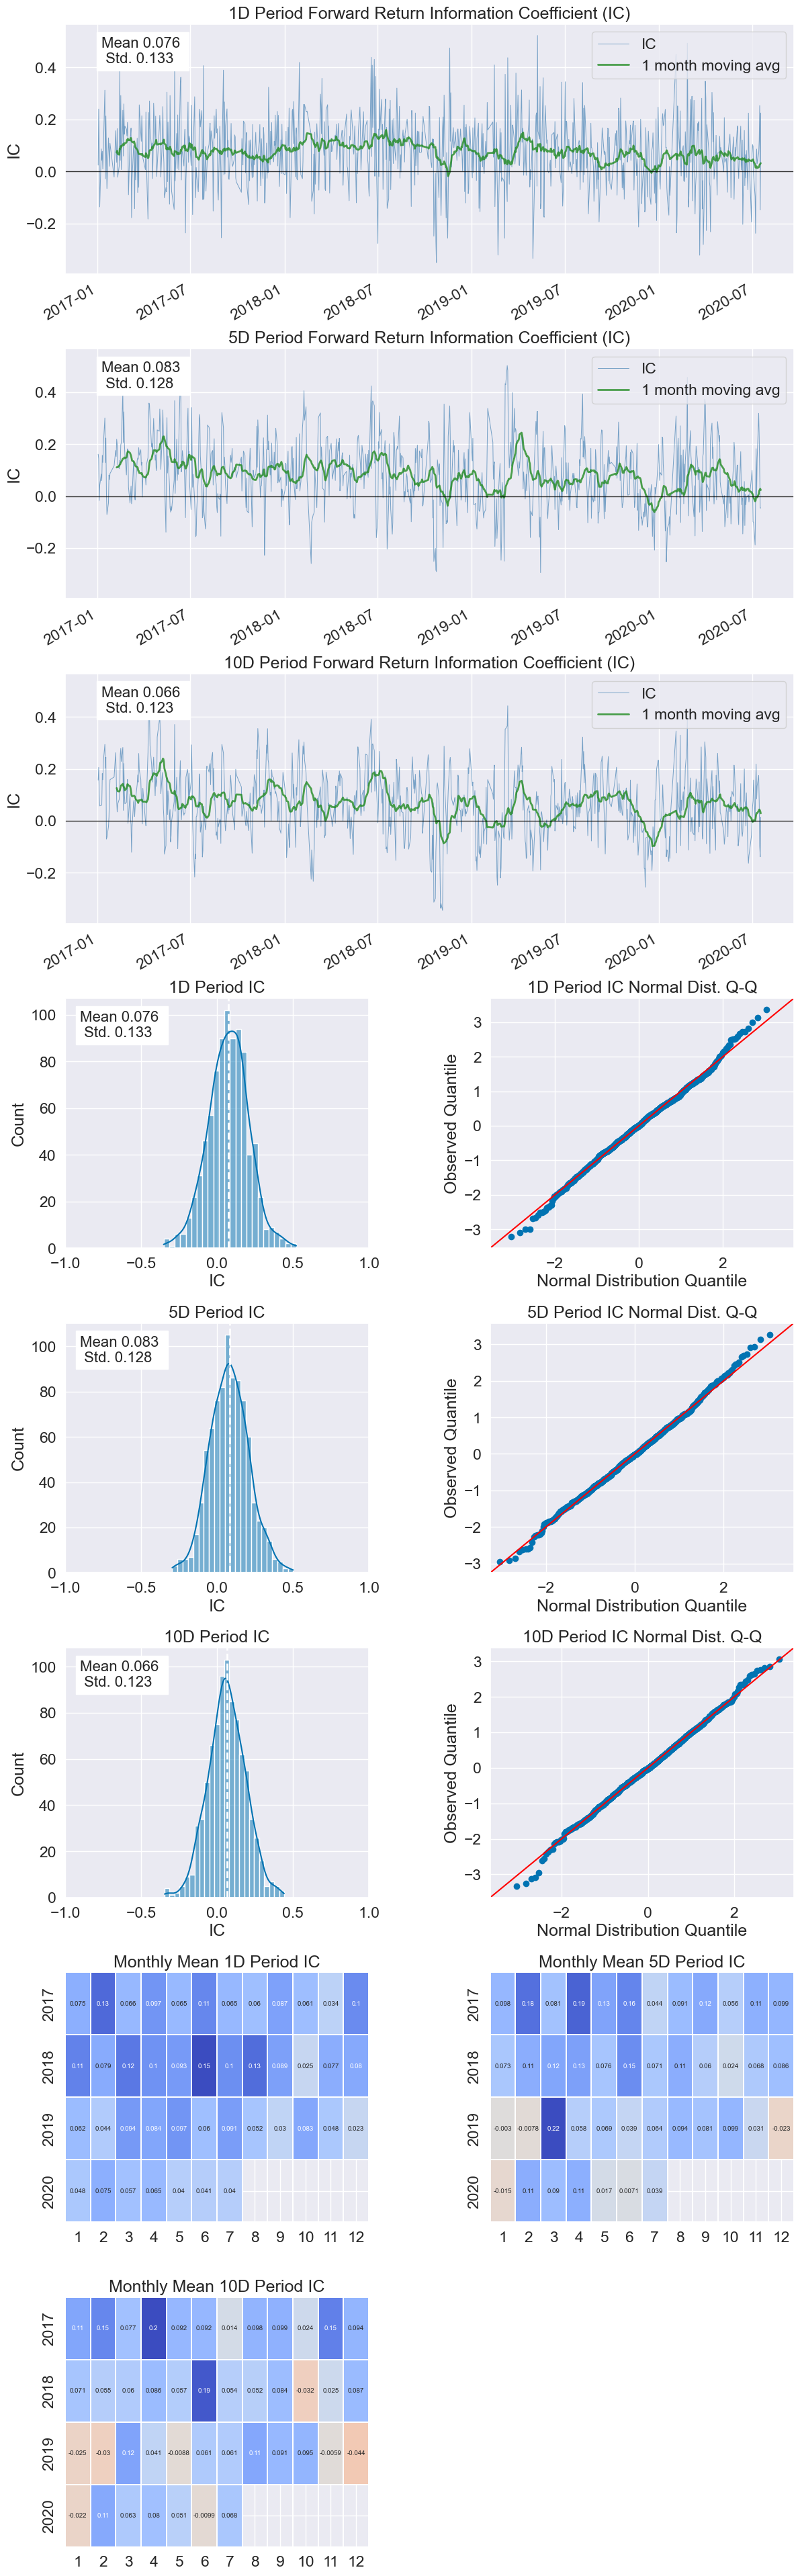

C:\Users\11986\AppData\Roaming\Python\Python312\site-packages\alphalens\utils.py:928: UserWarning:

Skipping return periods that aren't exact multiples of days.



Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover    0.584  0.806  0.835
Quantile 2 Mean Turnover    0.774  0.865  0.878
Quantile 3 Mean Turnover    0.824  0.877  0.884
Quantile 4 Mean Turnover    0.840  0.883  0.887
Quantile 5 Mean Turnover    0.845  0.886  0.893
Quantile 6 Mean Turnover    0.847  0.887  0.891
Quantile 7 Mean Turnover    0.830  0.882  0.893
Quantile 8 Mean Turnover    0.798  0.864  0.877
Quantile 9 Mean Turnover    0.747  0.852  0.865
Quantile 10 Mean Turnover   0.524  0.811  0.848

1D     5D    10D
Mean Factor Rank Autocorrelation  0.614  0.186  0.116

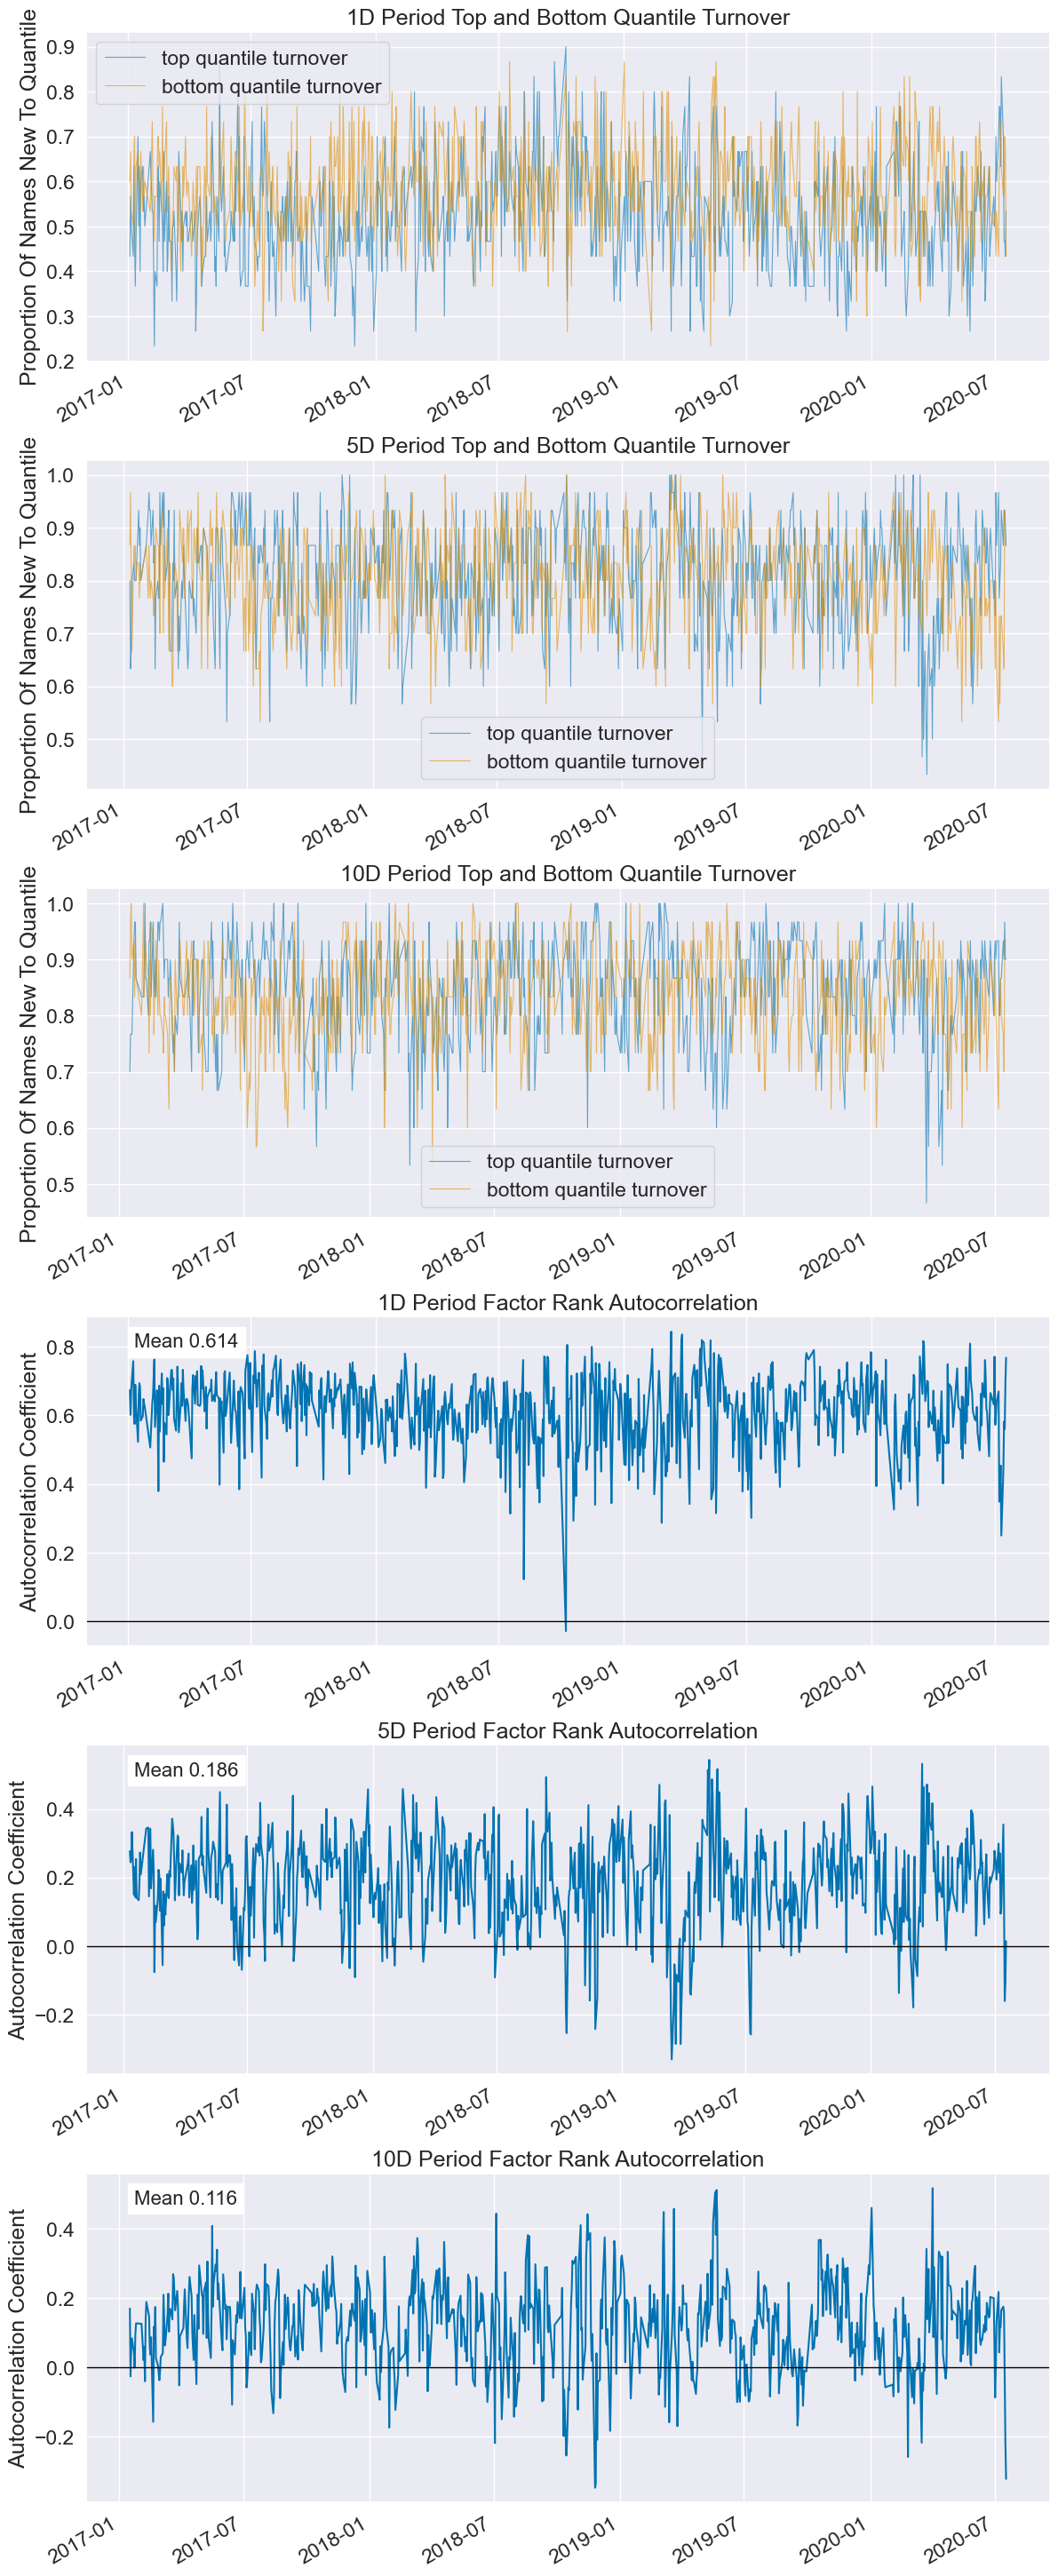

In [42]:
# 检查信号绩效
dataset.show_signal_performance(signal)

In [43]:
# 保存信号数据
lab.save_signal(name, signal)

# 策略回测

In [44]:
# 加载模块
import importlib
from datetime import datetime

from vnpy.alpha.strategy import BacktestingEngine

import vnpy.alpha.strategy.strategies.equity_demo_strategy as signal_strategy

In [45]:
# 重载策略类
importlib.reload(signal_strategy)
SignalStrategy = signal_strategy.EquityDemoStrategy

In [46]:
# 从文件加载信号数据
signal = lab.load_signal(name)

In [47]:
# 创建回测引擎对象
engine = BacktestingEngine(lab)

# 设置回测参数
engine.set_parameters(
    vt_symbols=component_symbols,
    interval=Interval.DAILY,
    start=datetime(2017, 1, 1),
    end=datetime(2020, 8, 1),
    capital=100000000
)

# 添加策略实例
setting = {"top_k": 30, "n_drop": 3, "hold_thresh": 3}
engine.add_strategy(SignalStrategy, setting, signal)

In [48]:
# 执行回测任务
engine.load_data()
engine.run_backtesting()
engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()

2025-07-24 23:20:06 开始加载历史数据


100%|██████████| 712/712 [00:07<00:00, 100.04it/s]

2025-07-24 23:20:13 部分合约历史数据为空：['600631.SSE', '600832.SSE', '600102.SSE', '600001.SSE', '601299.SSE', '600357.SSE', '601268.SSE', '600591.SSE', '000562.SZSE', '600087.SSE', '000024.SZSE', '600786.SSE', '000527.SZSE']


2025-07-24 23:20:13 所有历史数据加载完成
2025-07-24 23:20:13 策略初始化完成
2025-07-24 23:20:13 开始回放历史数据
2025-07-24 23:20:17 历史数据回放结束
2025-07-24 23:20:17 开始计算逐日盯市盈亏
2025-07-24 23:20:18 逐日盯市盈亏计算完成
2025-07-24 23:20:18 开始计算策略统计指标
2025-07-24 23:20:18 ------------------------------
2025-07-24 23:20:18 首个交易日：  2017-01-03
2025-07-24 23:20:18 最后交易日：  2020-07-31
2025-07-24 23:20:18 总交易日：  871
2025-07-24 23:20:18 盈利交易日：  478
2025-07-24 23:20:18 亏损交易日：  392
2025-07-24 23:20:18 起始资金：  100,000,000.00
2025-07-24 23:20:18 结束资金：  292,301,615.09
2025-07-24 23:20:18 总收益率：  192.30%
2025-07-24 23:20:18 年化收益：  52.99%
2025-07-24 23:20:18 最大回撤:   -48,822,126.88
2025-07-24 23:20:18 百分比最大回撤: -21.45%
2025-07-24 23:20:18 最长回撤天数:   18
2025-07-24 23:20:18 总盈亏：  192,301,615.09
2025-07-24 23:20:18 总手续费：  20,676,919.32
2025-07-24 23:20:18 总成交金额：  27,595,400,632.12
2025-07-24 23:20:18 总成交笔数：  4782
2025-07-24 23:20:18 日均盈亏：  220,782.57
2025-07-24 23:20:18 日均手续费：  23,739.29
2025-07-24 23:20:18 日均成交金额：  31,682,434.71
2025-07-24 23:20:18 

In [50]:
# 显示超额收益分析结果
engine.show_performance(benchmark_symbol=index_symbol)